In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets.folder import DatasetFolder
import torchvision
from torchvision import transforms, datasets
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
import sklearn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os

In [2]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [3]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7)
        self.act = nn.Mish()
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64,10)
        self.apply(self._init_weights)
        
    def _init_weights(self,m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.constant_(m.bias, 0)
            
    def forward(self,x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.conv3(x)
        x = self.act(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])
cifar_10_train = torchvision.datasets.CIFAR10(root='/kaggle/working/', train=True, transform=transform, download=True)
cifar_10_test = torchvision.datasets.CIFAR10(root='/kaggle/working/', train=False, transform=transform, download=True)
train_loader = DataLoader(cifar_10_train, batch_size=256, shuffle=False)
test_loader = DataLoader(cifar_10_test, batch_size=64, shuffle=False)
criterion = nn.CrossEntropyLoss()
model = CustomCNN()
model = model.cuda()
epochs=75
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
def predict(model, dataloader, epoch):
    model.eval()
    preds=[]
    test_acc=0
    pbar = pbar = tqdm(dataloader, desc=f"Test: Epoch {epoch+1}", total=len(dataloader), mininterval=5)
    with torch.no_grad():
        for images,labels in pbar:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            y_pred = F.softmax(outputs,dim = 1)
            top_p,top_class = y_pred.topk(1,dim = 1)
                
            label = labels.cpu().numpy()
            top_c = top_class.cpu().numpy() 
            test_acc += accuracy(outputs,labels)
    #torch.cuda.empty_cache()
    return test_acc/len(dataloader)

def training(model, dataloader, test_loader, epochs, optimizer):
    model_accs = []
    model_loss = []
    test_accs = []
    for ep in range(epochs):
        model.train()
        running_loss = 0
        train_accuracy = 0
        pbar = tqdm(dataloader, desc=f"Train: Epoch {ep + 1}", total=len(dataloader), mininterval=5)
        for images, labels in pbar:
            images = images.cuda()
            labels = labels.cuda()
            output = model(images)
            loss = criterion(output, labels)
            train_accuracy += accuracy(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix({"loss": loss.item()})
            running_loss += loss.item()
            
        loss = running_loss/len(dataloader)
        acc = train_accuracy/len(dataloader)
        model_accs.append(acc)
        model_loss.append(loss)
        print(f"Epoch {ep + 1} - Loss: {loss}")
        print(f"Epoch {ep + 1} - Acc: {acc}")
        test_acc = predict(model, test_loader, ep)
        test_accs.append(test_acc)
        print(f'Test Accuracy: {test_acc}')
    torch.cuda.empty_cache()
    return model_accs, model_loss, test_accs
train_acc_hist, train_loss_hist, test_accs = training(model, train_loader, test_loader, epochs, optimizer)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /kaggle/working/cifar-10-python.tar.gz to /kaggle/working/
Files already downloaded and verified


Train: Epoch 1: 100%|██████████| 196/196 [00:18<00:00, 10.38it/s, loss=1.58]


Epoch 1 - Loss: 1.7250092339758971
Epoch 1 - Acc: 0.37210220098495483


Test: Epoch 1: 100%|██████████| 157/157 [00:02<00:00, 61.52it/s]


Test Accuracy: 0.44735270738601685


Train: Epoch 2: 100%|██████████| 196/196 [00:14<00:00, 13.87it/s, loss=1.38]


Epoch 2 - Loss: 1.4009646621285652
Epoch 2 - Acc: 0.5011838674545288


Test: Epoch 2: 100%|██████████| 157/157 [00:02<00:00, 61.27it/s]


Test Accuracy: 0.5097531676292419


Train: Epoch 3: 100%|██████████| 196/196 [00:14<00:00, 13.46it/s, loss=1.27]


Epoch 3 - Loss: 1.2705812064968809
Epoch 3 - Acc: 0.5500279068946838


Test: Epoch 3: 100%|██████████| 157/157 [00:02<00:00, 58.92it/s]


Test Accuracy: 0.5573248267173767


Train: Epoch 4: 100%|██████████| 196/196 [00:13<00:00, 14.19it/s, loss=1.2]


Epoch 4 - Loss: 1.1820719838142395
Epoch 4 - Acc: 0.5834582448005676


Test: Epoch 4: 100%|██████████| 157/157 [00:02<00:00, 59.21it/s]


Test Accuracy: 0.5856887102127075


Train: Epoch 5: 100%|██████████| 196/196 [00:14<00:00, 13.47it/s, loss=1.13]


Epoch 5 - Loss: 1.11795908912104
Epoch 5 - Acc: 0.606425404548645


Test: Epoch 5: 100%|██████████| 157/157 [00:02<00:00, 61.21it/s]


Test Accuracy: 0.6050955653190613


Train: Epoch 6: 100%|██████████| 196/196 [00:14<00:00, 13.98it/s, loss=1.06]


Epoch 6 - Loss: 1.0668717951190716
Epoch 6 - Acc: 0.624601423740387


Test: Epoch 6: 100%|██████████| 157/157 [00:03<00:00, 50.30it/s]


Test Accuracy: 0.6206210255622864


Train: Epoch 7: 100%|██████████| 196/196 [00:14<00:00, 13.67it/s, loss=0.995]


Epoch 7 - Loss: 1.0239362081094665
Epoch 7 - Acc: 0.6390345692634583


Test: Epoch 7: 100%|██████████| 157/157 [00:02<00:00, 61.17it/s]


Test Accuracy: 0.6318670511245728


Train: Epoch 8: 100%|██████████| 196/196 [00:14<00:00, 13.71it/s, loss=0.949]


Epoch 8 - Loss: 0.9869966184606358
Epoch 8 - Acc: 0.653093159198761


Test: Epoch 8: 100%|██████████| 157/157 [00:02<00:00, 55.50it/s]


Test Accuracy: 0.6424164175987244


Train: Epoch 9: 100%|██████████| 196/196 [00:13<00:00, 14.22it/s, loss=0.915]


Epoch 9 - Loss: 0.9538358173200062
Epoch 9 - Acc: 0.6651387214660645


Test: Epoch 9: 100%|██████████| 157/157 [00:02<00:00, 62.70it/s]


Test Accuracy: 0.6505772471427917


Train: Epoch 10: 100%|██████████| 196/196 [00:14<00:00, 13.61it/s, loss=0.882]


Epoch 10 - Loss: 0.923559343024176
Epoch 10 - Acc: 0.6756815910339355


Test: Epoch 10: 100%|██████████| 157/157 [00:02<00:00, 60.88it/s]


Test Accuracy: 0.6610270738601685


Train: Epoch 11: 100%|██████████| 196/196 [00:13<00:00, 14.04it/s, loss=0.855]


Epoch 11 - Loss: 0.8962511143514088
Epoch 11 - Acc: 0.6847496628761292


Test: Epoch 11: 100%|██████████| 157/157 [00:02<00:00, 61.11it/s]


Test Accuracy: 0.668292224407196


Train: Epoch 12: 100%|██████████| 196/196 [00:14<00:00, 13.38it/s, loss=0.828]


Epoch 12 - Loss: 0.8714634821731218
Epoch 12 - Acc: 0.6939014792442322


Test: Epoch 12: 100%|██████████| 157/157 [00:02<00:00, 61.29it/s]


Test Accuracy: 0.6727706789970398


Train: Epoch 13: 100%|██████████| 196/196 [00:13<00:00, 14.10it/s, loss=0.8]


Epoch 13 - Loss: 0.8487154941777794
Epoch 13 - Acc: 0.7023158073425293


Test: Epoch 13: 100%|██████████| 157/157 [00:02<00:00, 61.10it/s]


Test Accuracy: 0.6800358295440674


Train: Epoch 14: 100%|██████████| 196/196 [00:14<00:00, 13.59it/s, loss=0.774]


Epoch 14 - Loss: 0.8275836116197158
Epoch 14 - Acc: 0.7102678418159485


Test: Epoch 14: 100%|██████████| 157/157 [00:02<00:00, 62.74it/s]


Test Accuracy: 0.6850119233131409


Train: Epoch 15: 100%|██████████| 196/196 [00:13<00:00, 14.19it/s, loss=0.747]


Epoch 15 - Loss: 0.8079720933218392
Epoch 15 - Acc: 0.7181600332260132


Test: Epoch 15: 100%|██████████| 157/157 [00:02<00:00, 61.77it/s]


Test Accuracy: 0.6886942386627197


Train: Epoch 16: 100%|██████████| 196/196 [00:14<00:00, 13.47it/s, loss=0.721]


Epoch 16 - Loss: 0.7899108167205539
Epoch 16 - Acc: 0.7249560952186584


Test: Epoch 16: 100%|██████████| 157/157 [00:02<00:00, 58.89it/s]


Test Accuracy: 0.694167971611023


Train: Epoch 17: 100%|██████████| 196/196 [00:14<00:00, 13.90it/s, loss=0.696]


Epoch 17 - Loss: 0.7734254781080752
Epoch 17 - Acc: 0.7310387492179871


Test: Epoch 17: 100%|██████████| 157/157 [00:02<00:00, 57.32it/s]


Test Accuracy: 0.6999402642250061


Train: Epoch 18: 100%|██████████| 196/196 [00:14<00:00, 13.41it/s, loss=0.672]


Epoch 18 - Loss: 0.7585155924364012
Epoch 18 - Acc: 0.7361646890640259


Test: Epoch 18: 100%|██████████| 157/157 [00:02<00:00, 62.27it/s]


Test Accuracy: 0.7030254602432251


Train: Epoch 19: 100%|██████████| 196/196 [00:14<00:00, 13.87it/s, loss=0.645]


Epoch 19 - Loss: 0.7445601300925625
Epoch 19 - Acc: 0.740429699420929


Test: Epoch 19: 100%|██████████| 157/157 [00:02<00:00, 57.10it/s]


Test Accuracy: 0.7046178579330444


Train: Epoch 20: 100%|██████████| 196/196 [00:14<00:00, 13.33it/s, loss=0.617]


Epoch 20 - Loss: 0.7306076187868508
Epoch 20 - Acc: 0.7463648319244385


Test: Epoch 20: 100%|██████████| 157/157 [00:02<00:00, 60.78it/s]


Test Accuracy: 0.7089968323707581


Train: Epoch 21: 100%|██████████| 196/196 [00:14<00:00, 13.83it/s, loss=0.594]


Epoch 21 - Loss: 0.7166911859293373
Epoch 21 - Acc: 0.7508569955825806


Test: Epoch 21: 100%|██████████| 157/157 [00:02<00:00, 56.34it/s]


Test Accuracy: 0.7127786874771118


Train: Epoch 22: 100%|██████████| 196/196 [00:14<00:00, 13.66it/s, loss=0.575]


Epoch 22 - Loss: 0.7032703149075411
Epoch 22 - Acc: 0.7552734613418579


Test: Epoch 22: 100%|██████████| 157/157 [00:02<00:00, 61.71it/s]


Test Accuracy: 0.7148686051368713


Train: Epoch 23: 100%|██████████| 196/196 [00:14<00:00, 13.76it/s, loss=0.557]


Epoch 23 - Loss: 0.6904906019264337
Epoch 23 - Acc: 0.7609574198722839


Test: Epoch 23: 100%|██████████| 157/157 [00:03<00:00, 50.04it/s]


Test Accuracy: 0.718550980091095


Train: Epoch 24: 100%|██████████| 196/196 [00:13<00:00, 14.01it/s, loss=0.539]


Epoch 24 - Loss: 0.6783274761876281
Epoch 24 - Acc: 0.7658243179321289


Test: Epoch 24: 100%|██████████| 157/157 [00:02<00:00, 60.55it/s]


Test Accuracy: 0.7211385369300842


Train: Epoch 25: 100%|██████████| 196/196 [00:14<00:00, 13.13it/s, loss=0.523]


Epoch 25 - Loss: 0.666715216879942
Epoch 25 - Acc: 0.7698341608047485


Test: Epoch 25: 100%|██████████| 157/157 [00:02<00:00, 59.66it/s]


Test Accuracy: 0.7238256335258484


Train: Epoch 26: 100%|██████████| 196/196 [00:13<00:00, 14.01it/s, loss=0.506]


Epoch 26 - Loss: 0.6555786144976713
Epoch 26 - Acc: 0.7735012769699097


Test: Epoch 26: 100%|██████████| 157/157 [00:02<00:00, 61.77it/s]


Test Accuracy: 0.7257165312767029


Train: Epoch 27: 100%|██████████| 196/196 [00:14<00:00, 13.48it/s, loss=0.491]


Epoch 27 - Loss: 0.6448616581607838
Epoch 27 - Acc: 0.7773956060409546


Test: Epoch 27: 100%|██████████| 157/157 [00:02<00:00, 61.32it/s]


Test Accuracy: 0.7281050682067871


Train: Epoch 28: 100%|██████████| 196/196 [00:14<00:00, 13.92it/s, loss=0.476]


Epoch 28 - Loss: 0.634491571358272
Epoch 28 - Acc: 0.7815489768981934


Test: Epoch 28: 100%|██████████| 157/157 [00:02<00:00, 62.52it/s]


Test Accuracy: 0.7297969460487366


Train: Epoch 29: 100%|██████████| 196/196 [00:14<00:00, 13.53it/s, loss=0.461]


Epoch 29 - Loss: 0.6244658408116321
Epoch 29 - Acc: 0.7852160334587097


Test: Epoch 29: 100%|██████████| 157/157 [00:02<00:00, 61.77it/s]


Test Accuracy: 0.7306926846504211


Train: Epoch 30: 100%|██████████| 196/196 [00:14<00:00, 13.97it/s, loss=0.448]


Epoch 30 - Loss: 0.6148084011309001
Epoch 30 - Acc: 0.7886878252029419


Test: Epoch 30: 100%|██████████| 157/157 [00:02<00:00, 58.69it/s]


Test Accuracy: 0.7317874431610107


Train: Epoch 31: 100%|██████████| 196/196 [00:14<00:00, 13.79it/s, loss=0.435]


Epoch 31 - Loss: 0.6054718754425341
Epoch 31 - Acc: 0.791796863079071


Test: Epoch 31: 100%|██████████| 157/157 [00:02<00:00, 62.68it/s]


Test Accuracy: 0.7334793210029602


Train: Epoch 32: 100%|██████████| 196/196 [00:13<00:00, 14.15it/s, loss=0.422]


Epoch 32 - Loss: 0.5964412680085824
Epoch 32 - Acc: 0.7951450943946838


Test: Epoch 32: 100%|██████████| 157/157 [00:02<00:00, 59.49it/s]


Test Accuracy: 0.7342754602432251


Train: Epoch 33: 100%|██████████| 196/196 [00:14<00:00, 13.83it/s, loss=0.41]


Epoch 33 - Loss: 0.5876905157858011
Epoch 33 - Acc: 0.7977160215377808


Test: Epoch 33: 100%|██████████| 157/157 [00:02<00:00, 62.35it/s]


Test Accuracy: 0.7357683181762695


Train: Epoch 34: 100%|██████████| 196/196 [00:14<00:00, 13.92it/s, loss=0.398]


Epoch 34 - Loss: 0.5792277870433671
Epoch 34 - Acc: 0.8012834787368774


Test: Epoch 34: 100%|██████████| 157/157 [00:02<00:00, 58.18it/s]


Test Accuracy: 0.7373606562614441


Train: Epoch 35: 100%|██████████| 196/196 [00:14<00:00, 13.59it/s, loss=0.386]


Epoch 35 - Loss: 0.5710834235865243
Epoch 35 - Acc: 0.8045718669891357


Test: Epoch 35: 100%|██████████| 157/157 [00:02<00:00, 60.31it/s]


Test Accuracy: 0.7385549545288086


Train: Epoch 36: 100%|██████████| 196/196 [00:14<00:00, 13.80it/s, loss=0.374]


Epoch 36 - Loss: 0.5632472682972344
Epoch 36 - Acc: 0.8077845573425293


Test: Epoch 36: 100%|██████████| 157/157 [00:02<00:00, 57.49it/s]


Test Accuracy: 0.7399482727050781


Train: Epoch 37: 100%|██████████| 196/196 [00:14<00:00, 13.40it/s, loss=0.363]


Epoch 37 - Loss: 0.5557213901561133
Epoch 37 - Acc: 0.8099967837333679


Test: Epoch 37: 100%|██████████| 157/157 [00:02<00:00, 61.52it/s]


Test Accuracy: 0.7399482727050781


Train: Epoch 38: 100%|██████████| 196/196 [00:14<00:00, 13.97it/s, loss=0.353]


Epoch 38 - Loss: 0.5484657485266121
Epoch 38 - Acc: 0.8129463791847229


Test: Epoch 38: 100%|██████████| 157/157 [00:03<00:00, 51.18it/s]


Test Accuracy: 0.7420381903648376


Train: Epoch 39: 100%|██████████| 196/196 [00:14<00:00, 13.70it/s, loss=0.342]


Epoch 39 - Loss: 0.5414758774698997
Epoch 39 - Acc: 0.8157166242599487


Test: Epoch 39: 100%|██████████| 157/157 [00:02<00:00, 59.83it/s]


Test Accuracy: 0.7430334687232971


Train: Epoch 40: 100%|██████████| 196/196 [00:14<00:00, 13.64it/s, loss=0.333]


Epoch 40 - Loss: 0.5347142908342031
Epoch 40 - Acc: 0.8183075189590454


Test: Epoch 40: 100%|██████████| 157/157 [00:02<00:00, 58.70it/s]


Test Accuracy: 0.743332028388977


Train: Epoch 41: 100%|██████████| 196/196 [00:14<00:00, 13.61it/s, loss=0.323]


Epoch 41 - Loss: 0.5281226437310783
Epoch 41 - Acc: 0.8207987546920776


Test: Epoch 41: 100%|██████████| 157/157 [00:02<00:00, 59.26it/s]


Test Accuracy: 0.7440286874771118


Train: Epoch 42: 100%|██████████| 196/196 [00:14<00:00, 13.44it/s, loss=0.314]


Epoch 42 - Loss: 0.5217370147607765
Epoch 42 - Acc: 0.8229312300682068


Test: Epoch 42: 100%|██████████| 157/157 [00:02<00:00, 59.81it/s]


Test Accuracy: 0.743630588054657


Train: Epoch 43: 100%|██████████| 196/196 [00:14<00:00, 13.67it/s, loss=0.305]


Epoch 43 - Loss: 0.5155642973829289
Epoch 43 - Acc: 0.825023889541626


Test: Epoch 43: 100%|██████████| 157/157 [00:02<00:00, 58.07it/s]


Test Accuracy: 0.743829607963562


Train: Epoch 44: 100%|██████████| 196/196 [00:14<00:00, 13.39it/s, loss=0.296]


Epoch 44 - Loss: 0.5095828345843724
Epoch 44 - Acc: 0.826961100101471


Test: Epoch 44: 100%|██████████| 157/157 [00:02<00:00, 60.40it/s]


Test Accuracy: 0.7432324886322021


Train: Epoch 45: 100%|██████████| 196/196 [00:14<00:00, 13.64it/s, loss=0.288]


Epoch 45 - Loss: 0.5037794660548774
Epoch 45 - Acc: 0.8294962048530579


Test: Epoch 45: 100%|██████████| 157/157 [00:02<00:00, 57.53it/s]


Test Accuracy: 0.7447253465652466


Train: Epoch 46: 100%|██████████| 196/196 [00:14<00:00, 13.12it/s, loss=0.279]


Epoch 46 - Loss: 0.49816783639241236
Epoch 46 - Acc: 0.831608772277832


Test: Epoch 46: 100%|██████████| 157/157 [00:02<00:00, 61.14it/s]


Test Accuracy: 0.7454219460487366


Train: Epoch 47: 100%|██████████| 196/196 [00:14<00:00, 14.00it/s, loss=0.271]


Epoch 47 - Loss: 0.49274306820363417
Epoch 47 - Acc: 0.8334861397743225


Test: Epoch 47: 100%|██████████| 157/157 [00:02<00:00, 61.32it/s]


Test Accuracy: 0.7463176846504211


Train: Epoch 48: 100%|██████████| 196/196 [00:14<00:00, 13.30it/s, loss=0.263]


Epoch 48 - Loss: 0.4875029328526283
Epoch 48 - Acc: 0.8351243734359741


Test: Epoch 48: 100%|██████████| 157/157 [00:02<00:00, 61.03it/s]


Test Accuracy: 0.7457205653190613


Train: Epoch 49: 100%|██████████| 196/196 [00:14<00:00, 13.83it/s, loss=0.256]


Epoch 49 - Loss: 0.4824300513279681
Epoch 49 - Acc: 0.8369219899177551


Test: Epoch 49: 100%|██████████| 157/157 [00:02<00:00, 59.51it/s]


Test Accuracy: 0.7461186051368713


Train: Epoch 50: 100%|██████████| 196/196 [00:14<00:00, 13.40it/s, loss=0.249]


Epoch 50 - Loss: 0.47751688820366955
Epoch 50 - Acc: 0.8387954235076904


Test: Epoch 50: 100%|██████████| 157/157 [00:02<00:00, 60.79it/s]


Test Accuracy: 0.7462181448936462


Train: Epoch 51: 100%|██████████| 196/196 [00:14<00:00, 13.82it/s, loss=0.242]


Epoch 51 - Loss: 0.4727189806194938
Epoch 51 - Acc: 0.8407285809516907


Test: Epoch 51: 100%|██████████| 157/157 [00:02<00:00, 53.99it/s]


Test Accuracy: 0.7465167045593262


Train: Epoch 52: 100%|██████████| 196/196 [00:14<00:00, 13.42it/s, loss=0.235]


Epoch 52 - Loss: 0.46803027642320616
Epoch 52 - Acc: 0.8422034382820129


Test: Epoch 52: 100%|██████████| 157/157 [00:02<00:00, 55.68it/s]


Test Accuracy: 0.7458200454711914


Train: Epoch 53: 100%|██████████| 196/196 [00:14<00:00, 13.35it/s, loss=0.229]


Epoch 53 - Loss: 0.46339830558518974
Epoch 53 - Acc: 0.8439173698425293


Test: Epoch 53: 100%|██████████| 157/157 [00:02<00:00, 58.57it/s]


Test Accuracy: 0.7476114630699158


Train: Epoch 54: 100%|██████████| 196/196 [00:14<00:00, 13.81it/s, loss=0.223]


Epoch 54 - Loss: 0.45878346081899135
Epoch 54 - Acc: 0.8456113934516907


Test: Epoch 54: 100%|██████████| 157/157 [00:02<00:00, 58.04it/s]


Test Accuracy: 0.7477110028266907


Train: Epoch 55: 100%|██████████| 196/196 [00:14<00:00, 13.31it/s, loss=0.218]


Epoch 55 - Loss: 0.4541629090601084
Epoch 55 - Acc: 0.8470105528831482


Test: Epoch 55: 100%|██████████| 157/157 [00:02<00:00, 56.63it/s]


Test Accuracy: 0.7479100227355957


Train: Epoch 56: 100%|██████████| 196/196 [00:14<00:00, 13.76it/s, loss=0.212]


Epoch 56 - Loss: 0.4495577728565858
Epoch 56 - Acc: 0.8487045764923096


Test: Epoch 56: 100%|██████████| 157/157 [00:02<00:00, 59.79it/s]


Test Accuracy: 0.7490047812461853


Train: Epoch 57: 100%|██████████| 196/196 [00:14<00:00, 13.35it/s, loss=0.208]


Epoch 57 - Loss: 0.44496715053611874
Epoch 57 - Acc: 0.8503388166427612


Test: Epoch 57: 100%|██████████| 157/157 [00:02<00:00, 61.33it/s]


Test Accuracy: 0.7494028806686401


Train: Epoch 58: 100%|██████████| 196/196 [00:14<00:00, 13.89it/s, loss=0.203]


Epoch 58 - Loss: 0.4403802815596668
Epoch 58 - Acc: 0.8526108264923096


Test: Epoch 58: 100%|██████████| 157/157 [00:02<00:00, 61.10it/s]


Test Accuracy: 0.7481091022491455


Train: Epoch 59: 100%|██████████| 196/196 [00:14<00:00, 13.15it/s, loss=0.199]


Epoch 59 - Loss: 0.4357861119265459
Epoch 59 - Acc: 0.8544045090675354


Test: Epoch 59: 100%|██████████| 157/157 [00:02<00:00, 57.40it/s]


Test Accuracy: 0.7484076619148254


Train: Epoch 60: 100%|██████████| 196/196 [00:14<00:00, 13.87it/s, loss=0.194]


Epoch 60 - Loss: 0.43123352938160603
Epoch 60 - Acc: 0.8555006980895996


Test: Epoch 60: 100%|██████████| 157/157 [00:02<00:00, 60.40it/s]


Test Accuracy: 0.7476114630699158


Train: Epoch 61: 100%|██████████| 196/196 [00:14<00:00, 13.17it/s, loss=0.19]


Epoch 61 - Loss: 0.42673116610670575
Epoch 61 - Acc: 0.8572186231613159


Test: Epoch 61: 100%|██████████| 157/157 [00:02<00:00, 58.91it/s]


Test Accuracy: 0.7485071420669556


Train: Epoch 62: 100%|██████████| 196/196 [00:14<00:00, 13.91it/s, loss=0.185]


Epoch 62 - Loss: 0.4223128990555296
Epoch 62 - Acc: 0.8591717481613159


Test: Epoch 62: 100%|██████████| 157/157 [00:02<00:00, 62.20it/s]


Test Accuracy: 0.7483081221580505


Train: Epoch 63: 100%|██████████| 196/196 [00:15<00:00, 12.93it/s, loss=0.181]


Epoch 63 - Loss: 0.4179668671318463
Epoch 63 - Acc: 0.8612245321273804


Test: Epoch 63: 100%|██████████| 157/157 [00:02<00:00, 62.33it/s]


Test Accuracy: 0.7491043210029602


Train: Epoch 64: 100%|██████████| 196/196 [00:13<00:00, 14.03it/s, loss=0.176]


Epoch 64 - Loss: 0.413685103004076
Epoch 64 - Acc: 0.8626993298530579


Test: Epoch 64: 100%|██████████| 157/157 [00:03<00:00, 52.09it/s]


Test Accuracy: 0.7487062215805054


Train: Epoch 65: 100%|██████████| 196/196 [00:14<00:00, 13.56it/s, loss=0.172]


Epoch 65 - Loss: 0.40948039764652444
Epoch 65 - Acc: 0.8644132614135742


Test: Epoch 65: 100%|██████████| 157/157 [00:02<00:00, 61.07it/s]


Test Accuracy: 0.7493033409118652


Train: Epoch 66: 100%|██████████| 196/196 [00:14<00:00, 13.94it/s, loss=0.169]


Epoch 66 - Loss: 0.4053381620621195
Epoch 66 - Acc: 0.865788459777832


Test: Epoch 66: 100%|██████████| 157/157 [00:02<00:00, 53.85it/s]


Test Accuracy: 0.7486066818237305


Train: Epoch 67: 100%|██████████| 196/196 [00:14<00:00, 13.43it/s, loss=0.165]


Epoch 67 - Loss: 0.4012099530319778
Epoch 67 - Acc: 0.866765022277832


Test: Epoch 67: 100%|██████████| 157/157 [00:02<00:00, 60.51it/s]


Test Accuracy: 0.7494028806686401


Train: Epoch 68: 100%|██████████| 196/196 [00:14<00:00, 13.71it/s, loss=0.162]


Epoch 68 - Loss: 0.39713501534899887
Epoch 68 - Acc: 0.8684789538383484


Test: Epoch 68: 100%|██████████| 157/157 [00:03<00:00, 50.69it/s]


Test Accuracy: 0.7506966590881348


Train: Epoch 69: 100%|██████████| 196/196 [00:14<00:00, 13.98it/s, loss=0.159]


Epoch 69 - Loss: 0.3930769666117065
Epoch 69 - Acc: 0.8703324198722839


Test: Epoch 69: 100%|██████████| 157/157 [00:02<00:00, 61.43it/s]


Test Accuracy: 0.7509952187538147


Train: Epoch 70: 100%|██████████| 196/196 [00:14<00:00, 13.33it/s, loss=0.156]


Epoch 70 - Loss: 0.38904891178316
Epoch 70 - Acc: 0.8718470931053162


Test: Epoch 70: 100%|██████████| 157/157 [00:02<00:00, 55.66it/s]


Test Accuracy: 0.7504976391792297


Train: Epoch 71: 100%|██████████| 196/196 [00:13<00:00, 14.20it/s, loss=0.154]


Epoch 71 - Loss: 0.3850624348436083
Epoch 71 - Acc: 0.8734016418457031


Test: Epoch 71: 100%|██████████| 157/157 [00:02<00:00, 62.56it/s]


Test Accuracy: 0.750199019908905


Train: Epoch 72: 100%|██████████| 196/196 [00:14<00:00, 13.36it/s, loss=0.151]


Epoch 72 - Loss: 0.3811181447639757
Epoch 72 - Acc: 0.8748565316200256


Test: Epoch 72: 100%|██████████| 157/157 [00:02<00:00, 57.73it/s]


Test Accuracy: 0.7503980994224548


Train: Epoch 73: 100%|██████████| 196/196 [00:14<00:00, 13.97it/s, loss=0.149]


Epoch 73 - Loss: 0.3772421409280933
Epoch 73 - Acc: 0.8768893480300903


Test: Epoch 73: 100%|██████████| 157/157 [00:02<00:00, 59.90it/s]


Test Accuracy: 0.7503980994224548


Train: Epoch 74: 100%|██████████| 196/196 [00:15<00:00, 13.02it/s, loss=0.147]


Epoch 74 - Loss: 0.3734281595264162
Epoch 74 - Acc: 0.8782246708869934


Test: Epoch 74: 100%|██████████| 157/157 [00:02<00:00, 61.02it/s]


Test Accuracy: 0.7502985596656799


Train: Epoch 75: 100%|██████████| 196/196 [00:13<00:00, 14.21it/s, loss=0.145]


Epoch 75 - Loss: 0.36967351979443
Epoch 75 - Acc: 0.8794762492179871


Test: Epoch 75: 100%|██████████| 157/157 [00:02<00:00, 62.08it/s]

Test Accuracy: 0.7504976391792297


In [5]:
#test_acc = predict(model, test_loader)
print(f'Test Accuracy on CIFAR-10 Test set: {max(test_accs)*100}%')

Test Accuracy on CIFAR-10 Test set: 75.09952545166016%


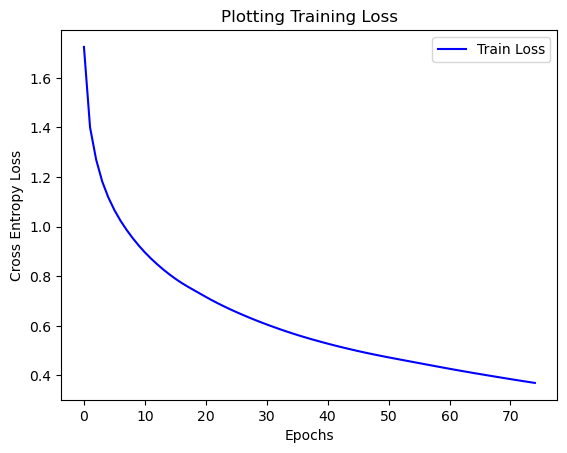

In [6]:
epochs_list = [i for i in range(epochs)]
plt.title('Plotting Training Loss')
plt.plot(epochs_list, train_loss_hist, 'b', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

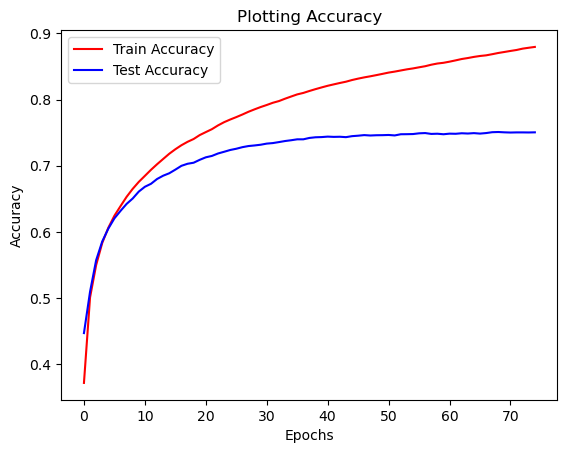

In [7]:
plt.title('Plotting Accuracy')
plt.plot(epochs_list, train_acc_hist, 'r', label='Train Accuracy')
plt.plot(epochs_list, test_accs, 'b', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

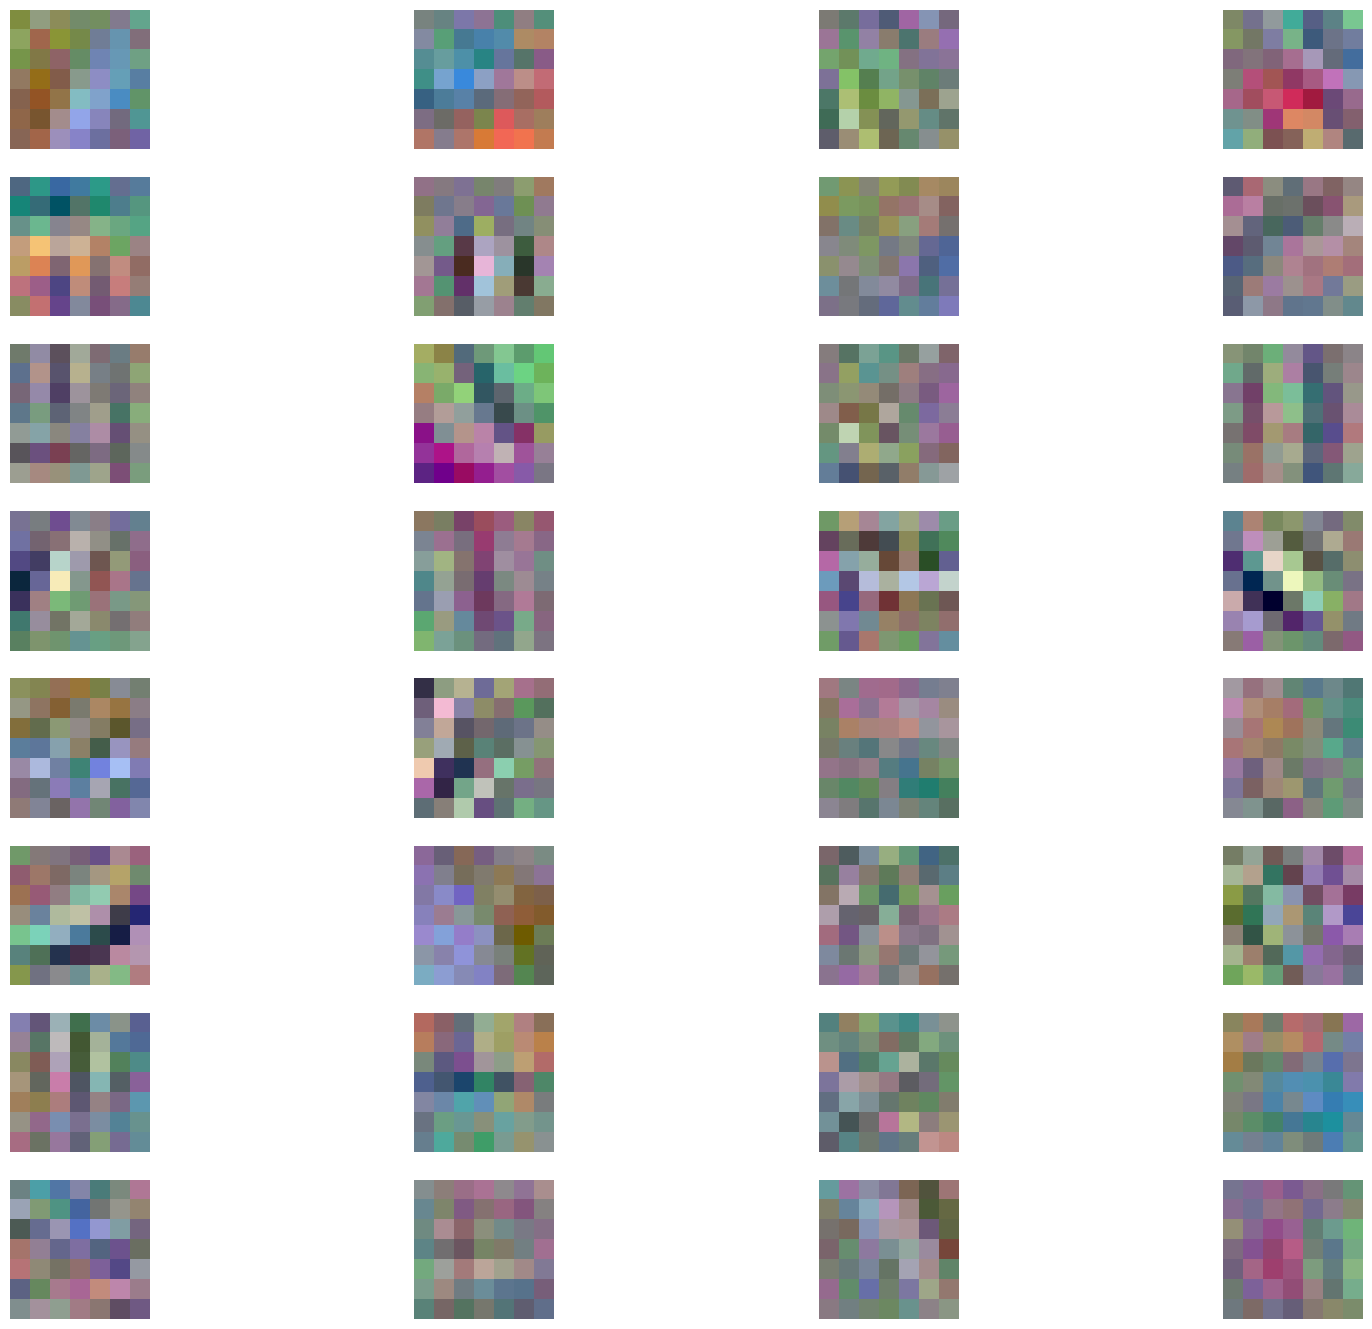

In [8]:
conv1_weights = model.conv1.weight.data.cpu().numpy()
plt.figure(figsize=(20, 17))
for i, filter in enumerate(conv1_weights):
    f = conv1_weights[i].transpose(1, 2, 0)
    norm = np.linalg.norm(f, ord=np.inf, axis=(0,1))
    eps = 1e-4
    normalized_filter = f/2*(norm + eps) + 0.5
    plt.subplot(8, 4, i+1)
    plt.imshow(normalized_filter)
    plt.axis('off')
    plt.savefig('filter.png')
plt.show()

# **Normalizing filters using min max scaling**

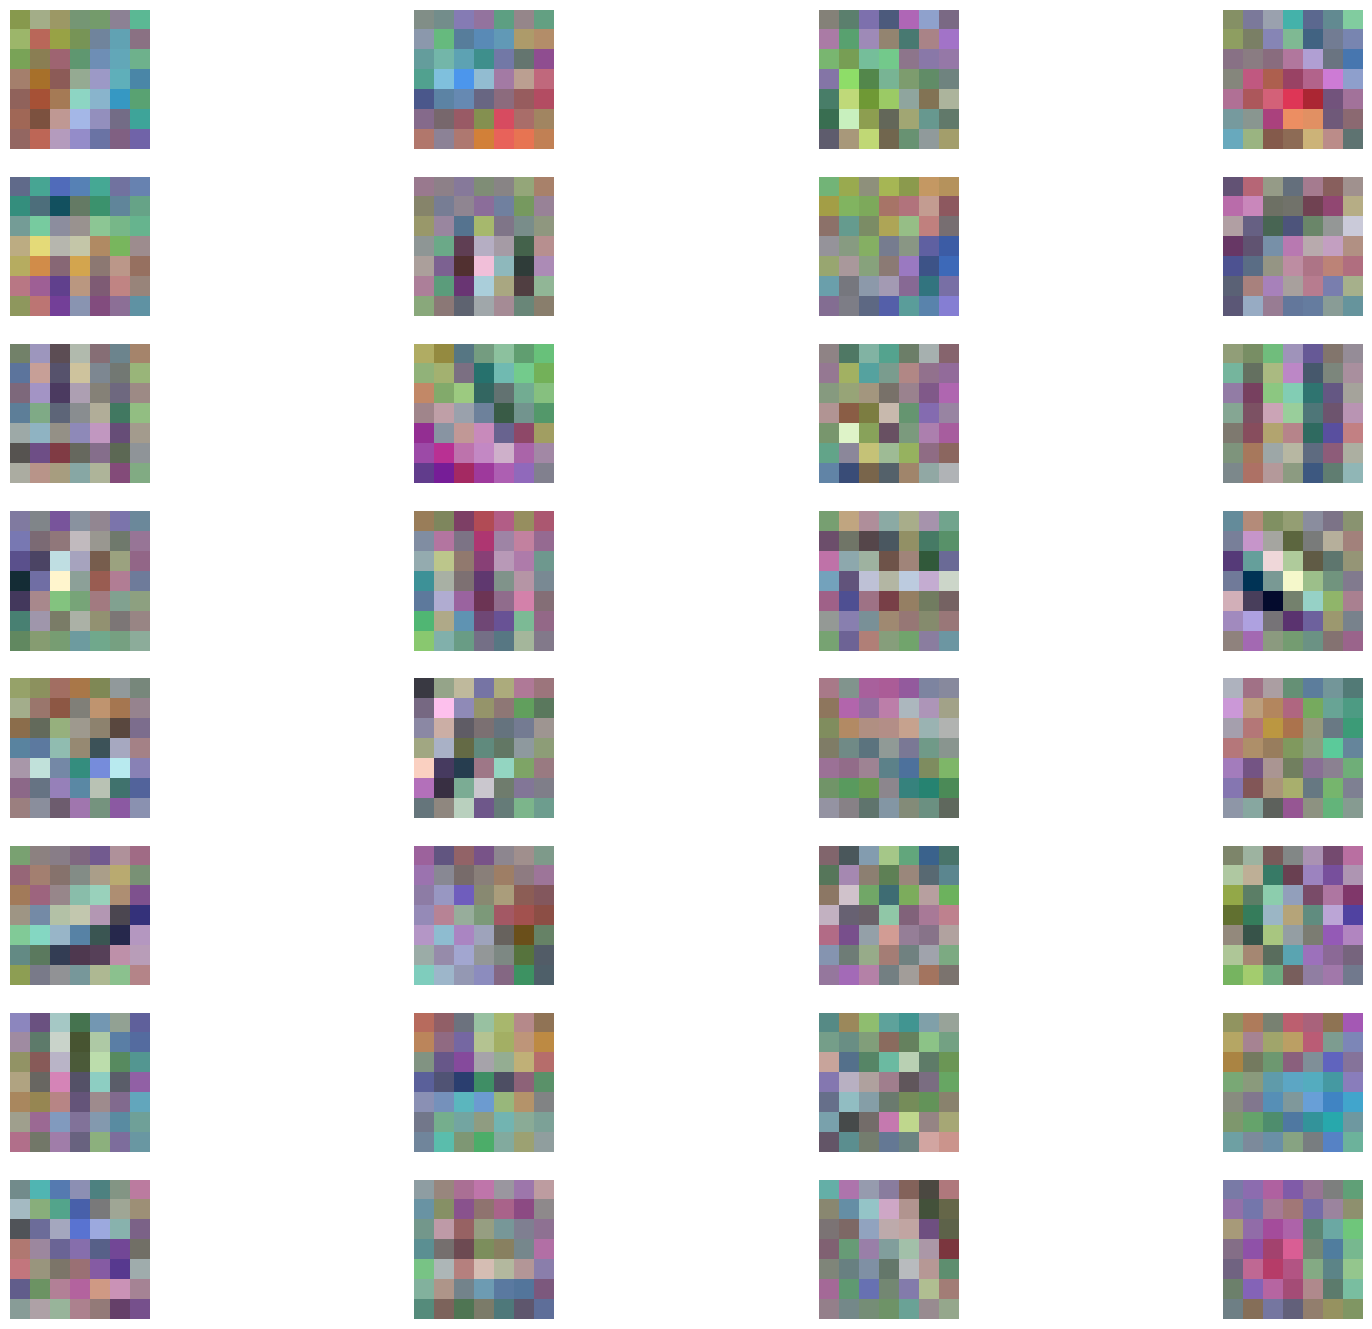

In [9]:
conv1_weights = model.conv1.weight.data.cpu().numpy()
conv1_weights = (conv1_weights - np.min(conv1_weights))/(np.max(conv1_weights) - np.min(conv1_weights))
plt.figure(figsize=(20, 17))
for i, filter in enumerate(conv1_weights):
    plt.subplot(8, 4, i+1)
    plt.imshow(conv1_weights[i].transpose(1, 2, 0))
    plt.axis('off')
    plt.savefig('filter_min_max_scaling.png')
plt.show()

In [10]:
class CustomCNNBN(nn.Module):
    def __init__(self):
        super(CustomCNNBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7)
        self.bn1 = nn.BatchNorm2d(32)
        self.act = nn.Mish()
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64,10)
        self.apply(self._init_weights)
        
    def _init_weights(self,m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight,1)
            torch.nn.init.constant_(m.bias,0)
            
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [11]:
model_bn = CustomCNNBN()
model_bn = model_bn.cuda()
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])
optimizer_bn = torch.optim.AdamW(model_bn.parameters(), lr=1e-3)
train_acc_hist_bn, train_loss_hist_bn, test_accs_bn = training(model_bn, train_loader, test_loader, epochs, optimizer_bn)

Train: Epoch 1: 100%|██████████| 196/196 [00:14<00:00, 13.27it/s, loss=1.45]


Epoch 1 - Loss: 1.5676219499841029
Epoch 1 - Acc: 0.4363081753253937


Test: Epoch 1: 100%|██████████| 157/157 [00:02<00:00, 62.84it/s]


Test Accuracy: 0.5113455653190613


Train: Epoch 2: 100%|██████████| 196/196 [00:14<00:00, 13.78it/s, loss=1.26]


Epoch 2 - Loss: 1.2820378177020015
Epoch 2 - Acc: 0.546452522277832


Test: Epoch 2: 100%|██████████| 157/157 [00:02<00:00, 60.28it/s]


Test Accuracy: 0.5710589289665222


Train: Epoch 3: 100%|██████████| 196/196 [00:14<00:00, 13.72it/s, loss=1.13]


Epoch 3 - Loss: 1.154789930095478
Epoch 3 - Acc: 0.5928252339363098


Test: Epoch 3: 100%|██████████| 157/157 [00:02<00:00, 63.28it/s]


Test Accuracy: 0.6075835824012756


Train: Epoch 4: 100%|██████████| 196/196 [00:14<00:00, 13.50it/s, loss=1.03]


Epoch 4 - Loss: 1.0731726386109177
Epoch 4 - Acc: 0.6226961016654968


Test: Epoch 4: 100%|██████████| 157/157 [00:03<00:00, 51.56it/s]


Test Accuracy: 0.6286823153495789


Train: Epoch 5: 100%|██████████| 196/196 [00:13<00:00, 14.17it/s, loss=0.949]


Epoch 5 - Loss: 1.015012848438049
Epoch 5 - Acc: 0.6435945630073547


Test: Epoch 5: 100%|██████████| 157/157 [00:02<00:00, 62.96it/s]


Test Accuracy: 0.6440087556838989


Train: Epoch 6: 100%|██████████| 196/196 [00:14<00:00, 13.23it/s, loss=0.877]


Epoch 6 - Loss: 0.9687501681702477
Epoch 6 - Acc: 0.6598493456840515


Test: Epoch 6: 100%|██████████| 157/157 [00:02<00:00, 59.18it/s]


Test Accuracy: 0.6548566818237305


Train: Epoch 7: 100%|██████████| 196/196 [00:13<00:00, 14.33it/s, loss=0.819]


Epoch 7 - Loss: 0.92925604417616
Epoch 7 - Acc: 0.6750040054321289


Test: Epoch 7: 100%|██████████| 157/157 [00:02<00:00, 61.87it/s]


Test Accuracy: 0.668789803981781


Train: Epoch 8: 100%|██████████| 196/196 [00:15<00:00, 13.05it/s, loss=0.774]


Epoch 8 - Loss: 0.8940848005669457
Epoch 8 - Acc: 0.6861526966094971


Test: Epoch 8: 100%|██████████| 157/157 [00:02<00:00, 60.38it/s]


Test Accuracy: 0.6779458522796631


Train: Epoch 9: 100%|██████████| 196/196 [00:13<00:00, 14.21it/s, loss=0.737]


Epoch 9 - Loss: 0.8624312047447477
Epoch 9 - Acc: 0.6975087523460388


Test: Epoch 9: 100%|██████████| 157/157 [00:02<00:00, 61.80it/s]


Test Accuracy: 0.6863057613372803


Train: Epoch 10: 100%|██████████| 196/196 [00:14<00:00, 13.21it/s, loss=0.703]


Epoch 10 - Loss: 0.8338699657089856
Epoch 10 - Acc: 0.7087531685829163


Test: Epoch 10: 100%|██████████| 157/157 [00:02<00:00, 59.93it/s]


Test Accuracy: 0.6923766136169434


Train: Epoch 11: 100%|██████████| 196/196 [00:13<00:00, 14.25it/s, loss=0.671]


Epoch 11 - Loss: 0.8080556888361367
Epoch 11 - Acc: 0.7190848588943481


Test: Epoch 11: 100%|██████████| 157/157 [00:02<00:00, 61.48it/s]


Test Accuracy: 0.7004379034042358


Train: Epoch 12: 100%|██████████| 196/196 [00:14<00:00, 13.13it/s, loss=0.642]


Epoch 12 - Loss: 0.7846413659197944
Epoch 12 - Acc: 0.7279496192932129


Test: Epoch 12: 100%|██████████| 157/157 [00:02<00:00, 63.15it/s]


Test Accuracy: 0.7051154375076294


Train: Epoch 13: 100%|██████████| 196/196 [00:13<00:00, 14.15it/s, loss=0.615]


Epoch 13 - Loss: 0.7633170296951216
Epoch 13 - Acc: 0.7346859574317932


Test: Epoch 13: 100%|██████████| 157/157 [00:02<00:00, 61.88it/s]


Test Accuracy: 0.7086982727050781


Train: Epoch 14: 100%|██████████| 196/196 [00:15<00:00, 13.05it/s, loss=0.591]


Epoch 14 - Loss: 0.7437813431024551
Epoch 14 - Acc: 0.7413942813873291


Test: Epoch 14: 100%|██████████| 157/157 [00:02<00:00, 62.20it/s]


Test Accuracy: 0.7121815085411072


Train: Epoch 15: 100%|██████████| 196/196 [00:13<00:00, 14.09it/s, loss=0.569]


Epoch 15 - Loss: 0.7257877162524632
Epoch 15 - Acc: 0.748469352722168


Test: Epoch 15: 100%|██████████| 157/157 [00:02<00:00, 60.61it/s]


Test Accuracy: 0.7133758068084717


Train: Epoch 16: 100%|██████████| 196/196 [00:14<00:00, 13.29it/s, loss=0.548]


Epoch 16 - Loss: 0.7090228911565275
Epoch 16 - Acc: 0.7541732788085938


Test: Epoch 16: 100%|██████████| 157/157 [00:02<00:00, 63.35it/s]


Test Accuracy: 0.715465784072876


Train: Epoch 17: 100%|██████████| 196/196 [00:13<00:00, 14.25it/s, loss=0.53]


Epoch 17 - Loss: 0.6933384784022156
Epoch 17 - Acc: 0.7604153752326965


Test: Epoch 17: 100%|██████████| 157/157 [00:02<00:00, 63.97it/s]


Test Accuracy: 0.7173566818237305


Train: Epoch 18: 100%|██████████| 196/196 [00:15<00:00, 12.79it/s, loss=0.512]


Epoch 18 - Loss: 0.6786013564893177
Epoch 18 - Acc: 0.7660355567932129


Test: Epoch 18: 100%|██████████| 157/157 [00:02<00:00, 62.02it/s]


Test Accuracy: 0.7196456789970398


Train: Epoch 19: 100%|██████████| 196/196 [00:13<00:00, 14.20it/s, loss=0.496]


Epoch 19 - Loss: 0.6647389613243998
Epoch 19 - Acc: 0.7716956734657288


Test: Epoch 19: 100%|██████████| 157/157 [00:03<00:00, 49.23it/s]


Test Accuracy: 0.7228304147720337


Train: Epoch 20: 100%|██████████| 196/196 [00:14<00:00, 13.50it/s, loss=0.48]


Epoch 20 - Loss: 0.6516814823357426
Epoch 20 - Acc: 0.7763233780860901


Test: Epoch 20: 100%|██████████| 157/157 [00:02<00:00, 60.55it/s]


Test Accuracy: 0.725417971611023


Train: Epoch 21: 100%|██████████| 196/196 [00:14<00:00, 13.91it/s, loss=0.465]


Epoch 21 - Loss: 0.6393728244061373
Epoch 21 - Acc: 0.7800701856613159


Test: Epoch 21: 100%|██████████| 157/157 [00:02<00:00, 59.46it/s]


Test Accuracy: 0.728204607963562


Train: Epoch 22: 100%|██████████| 196/196 [00:14<00:00, 13.67it/s, loss=0.451]


Epoch 22 - Loss: 0.6277250507656409
Epoch 22 - Acc: 0.7844786643981934


Test: Epoch 22: 100%|██████████| 157/157 [00:02<00:00, 61.88it/s]


Test Accuracy: 0.7302945852279663


Train: Epoch 23: 100%|██████████| 196/196 [00:14<00:00, 13.86it/s, loss=0.436]


Epoch 23 - Loss: 0.6166717466347071
Epoch 23 - Acc: 0.7886439561843872


Test: Epoch 23: 100%|██████████| 157/157 [00:02<00:00, 60.58it/s]


Test Accuracy: 0.731488823890686


Train: Epoch 24: 100%|██████████| 196/196 [00:14<00:00, 13.60it/s, loss=0.423]


Epoch 24 - Loss: 0.6062181931065054
Epoch 24 - Acc: 0.7917370796203613


Test: Epoch 24: 100%|██████████| 157/157 [00:02<00:00, 61.04it/s]


Test Accuracy: 0.731488823890686


Train: Epoch 25: 100%|██████████| 196/196 [00:14<00:00, 13.81it/s, loss=0.409]


Epoch 25 - Loss: 0.596295810171536
Epoch 25 - Acc: 0.7950454354286194


Test: Epoch 25: 100%|██████████| 157/157 [00:02<00:00, 62.14it/s]


Test Accuracy: 0.7321854829788208


Train: Epoch 26: 100%|██████████| 196/196 [00:14<00:00, 13.48it/s, loss=0.395]


Epoch 26 - Loss: 0.5868010037407583
Epoch 26 - Acc: 0.7979950308799744


Test: Epoch 26: 100%|██████████| 157/157 [00:02<00:00, 62.06it/s]


Test Accuracy: 0.7326831221580505


Train: Epoch 27: 100%|██████████| 196/196 [00:14<00:00, 13.78it/s, loss=0.382]


Epoch 27 - Loss: 0.5777090813736526
Epoch 27 - Acc: 0.8016621470451355


Test: Epoch 27: 100%|██████████| 157/157 [00:02<00:00, 61.97it/s]


Test Accuracy: 0.7337778806686401


Train: Epoch 28: 100%|██████████| 196/196 [00:14<00:00, 13.43it/s, loss=0.368]


Epoch 28 - Loss: 0.5689805746078491
Epoch 28 - Acc: 0.8049944043159485


Test: Epoch 28: 100%|██████████| 157/157 [00:02<00:00, 60.17it/s]


Test Accuracy: 0.7347730994224548


Train: Epoch 29: 100%|██████████| 196/196 [00:14<00:00, 13.63it/s, loss=0.354]


Epoch 29 - Loss: 0.5605529155962321
Epoch 29 - Acc: 0.8077247738838196


Test: Epoch 29: 100%|██████████| 157/157 [00:02<00:00, 62.77it/s]


Test Accuracy: 0.7348726391792297


Train: Epoch 30: 100%|██████████| 196/196 [00:14<00:00, 13.69it/s, loss=0.34]


Epoch 30 - Loss: 0.5524416908013577
Epoch 30 - Acc: 0.8103355765342712


Test: Epoch 30: 100%|██████████| 157/157 [00:02<00:00, 64.20it/s]


Test Accuracy: 0.7365645170211792


Train: Epoch 31: 100%|██████████| 196/196 [00:14<00:00, 13.85it/s, loss=0.326]


Epoch 31 - Loss: 0.544620795821657
Epoch 31 - Acc: 0.8131855726242065


Test: Epoch 31: 100%|██████████| 157/157 [00:02<00:00, 64.17it/s]


Test Accuracy: 0.7392516136169434


Train: Epoch 32: 100%|██████████| 196/196 [00:14<00:00, 13.52it/s, loss=0.313]


Epoch 32 - Loss: 0.5371103587807441
Epoch 32 - Acc: 0.8158442378044128


Test: Epoch 32: 100%|██████████| 157/157 [00:02<00:00, 60.50it/s]


Test Accuracy: 0.7417396306991577


Train: Epoch 33: 100%|██████████| 196/196 [00:14<00:00, 13.89it/s, loss=0.301]


Epoch 33 - Loss: 0.5298463898349781
Epoch 33 - Acc: 0.818953275680542


Test: Epoch 33: 100%|██████████| 157/157 [00:02<00:00, 62.96it/s]


Test Accuracy: 0.7427348494529724


Train: Epoch 34: 100%|██████████| 196/196 [00:14<00:00, 13.78it/s, loss=0.29]


Epoch 34 - Loss: 0.5227826865656036
Epoch 34 - Acc: 0.8219866156578064


Test: Epoch 34: 100%|██████████| 157/157 [00:02<00:00, 53.42it/s]


Test Accuracy: 0.7445262670516968


Train: Epoch 35: 100%|██████████| 196/196 [00:13<00:00, 14.25it/s, loss=0.28]


Epoch 35 - Loss: 0.5159036806043313
Epoch 35 - Acc: 0.8248365521430969


Test: Epoch 35: 100%|██████████| 157/157 [00:02<00:00, 62.21it/s]


Test Accuracy: 0.7448248267173767


Train: Epoch 36: 100%|██████████| 196/196 [00:14<00:00, 13.58it/s, loss=0.269]


Epoch 36 - Loss: 0.5092160481275344
Epoch 36 - Acc: 0.826973021030426


Test: Epoch 36: 100%|██████████| 157/157 [00:03<00:00, 52.29it/s]


Test Accuracy: 0.7454219460487366


Train: Epoch 37: 100%|██████████| 196/196 [00:13<00:00, 14.41it/s, loss=0.259]


Epoch 37 - Loss: 0.5028138133336086
Epoch 37 - Acc: 0.8293645977973938


Test: Epoch 37: 100%|██████████| 157/157 [00:02<00:00, 63.28it/s]


Test Accuracy: 0.7473129034042358


Train: Epoch 38: 100%|██████████| 196/196 [00:14<00:00, 13.48it/s, loss=0.25]


Epoch 38 - Loss: 0.4970166605650162
Epoch 38 - Acc: 0.831839919090271


Test: Epoch 38: 100%|██████████| 157/157 [00:02<00:00, 60.67it/s]


Test Accuracy: 0.750199019908905


Train: Epoch 39: 100%|██████████| 196/196 [00:13<00:00, 14.55it/s, loss=0.244]


Epoch 39 - Loss: 0.49148987857054693
Epoch 39 - Acc: 0.8345304131507874


Test: Epoch 39: 100%|██████████| 157/157 [00:02<00:00, 64.15it/s]


Test Accuracy: 0.7539808750152588


Train: Epoch 40: 100%|██████████| 196/196 [00:14<00:00, 13.17it/s, loss=0.235]


Epoch 40 - Loss: 0.4849997997588041
Epoch 40 - Acc: 0.8368223309516907


Test: Epoch 40: 100%|██████████| 157/157 [00:02<00:00, 63.63it/s]


Test Accuracy: 0.7575637102127075


Train: Epoch 41: 100%|██████████| 196/196 [00:13<00:00, 14.15it/s, loss=0.226]


Epoch 41 - Loss: 0.47772189123289927
Epoch 41 - Acc: 0.8401705622673035


Test: Epoch 41: 100%|██████████| 157/157 [00:02<00:00, 61.60it/s]


Test Accuracy: 0.7596536874771118


Train: Epoch 42: 100%|██████████| 196/196 [00:15<00:00, 12.96it/s, loss=0.219]


Epoch 42 - Loss: 0.4707149902776796
Epoch 42 - Acc: 0.8428611159324646


Test: Epoch 42: 100%|██████████| 157/157 [00:02<00:00, 62.72it/s]


Test Accuracy: 0.7611464858055115


Train: Epoch 43: 100%|██████████| 196/196 [00:13<00:00, 14.10it/s, loss=0.212]


Epoch 43 - Loss: 0.4640987314740006
Epoch 43 - Acc: 0.8451331257820129


Test: Epoch 43: 100%|██████████| 157/157 [00:02<00:00, 61.54it/s]


Test Accuracy: 0.7626393437385559


Train: Epoch 44: 100%|██████████| 196/196 [00:14<00:00, 13.07it/s, loss=0.206]


Epoch 44 - Loss: 0.45775650791367706
Epoch 44 - Acc: 0.8475486636161804


Test: Epoch 44: 100%|██████████| 157/157 [00:02<00:00, 61.76it/s]


Test Accuracy: 0.7641321420669556


Train: Epoch 45: 100%|██████████| 196/196 [00:13<00:00, 14.25it/s, loss=0.2]


Epoch 45 - Loss: 0.45160437116817553
Epoch 45 - Acc: 0.8499203324317932


Test: Epoch 45: 100%|██████████| 157/157 [00:02<00:00, 62.88it/s]


Test Accuracy: 0.7649283409118652


Train: Epoch 46: 100%|██████████| 196/196 [00:15<00:00, 13.04it/s, loss=0.195]


Epoch 46 - Loss: 0.4455817569123239
Epoch 46 - Acc: 0.8519730567932129


Test: Epoch 46: 100%|██████████| 157/157 [00:02<00:00, 61.13it/s]


Test Accuracy: 0.7639331221580505


Train: Epoch 47: 100%|██████████| 196/196 [00:13<00:00, 14.22it/s, loss=0.19]


Epoch 47 - Loss: 0.4396989964404885
Epoch 47 - Acc: 0.8546038269996643


Test: Epoch 47: 100%|██████████| 157/157 [00:02<00:00, 62.54it/s]


Test Accuracy: 0.7639331221580505


Train: Epoch 48: 100%|██████████| 196/196 [00:14<00:00, 13.17it/s, loss=0.186]


Epoch 48 - Loss: 0.43392823575710765
Epoch 48 - Acc: 0.8569157123565674


Test: Epoch 48: 100%|██████████| 157/157 [00:02<00:00, 64.18it/s]


Test Accuracy: 0.7649283409118652


Train: Epoch 49: 100%|██████████| 196/196 [00:13<00:00, 14.74it/s, loss=0.181]


Epoch 49 - Loss: 0.4282892723472751
Epoch 49 - Acc: 0.8589286208152771


Test: Epoch 49: 100%|██████████| 157/157 [00:02<00:00, 62.70it/s]


Test Accuracy: 0.765425980091095


Train: Epoch 50: 100%|██████████| 196/196 [00:14<00:00, 13.38it/s, loss=0.177]


Epoch 50 - Loss: 0.4227760396897793
Epoch 50 - Acc: 0.8615992069244385


Test: Epoch 50: 100%|██████████| 157/157 [00:02<00:00, 65.02it/s]


Test Accuracy: 0.7660230994224548


Train: Epoch 51: 100%|██████████| 196/196 [00:13<00:00, 14.68it/s, loss=0.174]


Epoch 51 - Loss: 0.41736034661227345
Epoch 51 - Acc: 0.8634925484657288


Test: Epoch 51: 100%|██████████| 157/157 [00:02<00:00, 64.03it/s]


Test Accuracy: 0.7659235596656799


Train: Epoch 52: 100%|██████████| 196/196 [00:14<00:00, 13.25it/s, loss=0.17]


Epoch 52 - Loss: 0.4120427567739876
Epoch 52 - Acc: 0.8652862310409546


Test: Epoch 52: 100%|██████████| 157/157 [00:02<00:00, 63.44it/s]


Test Accuracy: 0.7664211988449097


Train: Epoch 53: 100%|██████████| 196/196 [00:13<00:00, 14.81it/s, loss=0.167]


Epoch 53 - Loss: 0.40680697765581464
Epoch 53 - Acc: 0.8673987984657288


Test: Epoch 53: 100%|██████████| 157/157 [00:02<00:00, 55.73it/s]


Test Accuracy: 0.765824019908905


Train: Epoch 54: 100%|██████████| 196/196 [00:14<00:00, 13.72it/s, loss=0.163]


Epoch 54 - Loss: 0.40166190464277657
Epoch 54 - Acc: 0.8694714903831482


Test: Epoch 54: 100%|██████████| 157/157 [00:02<00:00, 65.47it/s]


Test Accuracy: 0.7661226391792297


Train: Epoch 55: 100%|██████████| 196/196 [00:13<00:00, 14.99it/s, loss=0.16]


Epoch 55 - Loss: 0.39660735724835977
Epoch 55 - Acc: 0.8716278672218323


Test: Epoch 55: 100%|██████████| 157/157 [00:02<00:00, 53.50it/s]


Test Accuracy: 0.7649283409118652


Train: Epoch 56: 100%|██████████| 196/196 [00:14<00:00, 13.57it/s, loss=0.157]


Epoch 56 - Loss: 0.39165864626363833
Epoch 56 - Acc: 0.8731425404548645


Test: Epoch 56: 100%|██████████| 157/157 [00:02<00:00, 64.59it/s]


Test Accuracy: 0.7653264403343201


Train: Epoch 57: 100%|██████████| 196/196 [00:13<00:00, 14.69it/s, loss=0.155]


Epoch 57 - Loss: 0.3867952587957285
Epoch 57 - Acc: 0.8753746747970581


Test: Epoch 57: 100%|██████████| 157/157 [00:02<00:00, 53.91it/s]


Test Accuracy: 0.7660230994224548


Train: Epoch 58: 100%|██████████| 196/196 [00:14<00:00, 13.70it/s, loss=0.152]


Epoch 58 - Loss: 0.38201148747181407
Epoch 58 - Acc: 0.8776068687438965


Test: Epoch 58: 100%|██████████| 157/157 [00:02<00:00, 64.89it/s]


Test Accuracy: 0.7652269005775452


Train: Epoch 59: 100%|██████████| 196/196 [00:13<00:00, 14.55it/s, loss=0.149]


Epoch 59 - Loss: 0.3773356577267452
Epoch 59 - Acc: 0.879484236240387


Test: Epoch 59: 100%|██████████| 157/157 [00:02<00:00, 62.32it/s]


Test Accuracy: 0.7660230994224548


Train: Epoch 60: 100%|██████████| 196/196 [00:14<00:00, 13.88it/s, loss=0.147]


Epoch 60 - Loss: 0.37275753641615106
Epoch 60 - Acc: 0.8809390664100647


Test: Epoch 60: 100%|██████████| 157/157 [00:02<00:00, 64.01it/s]


Test Accuracy: 0.7652269005775452


Train: Epoch 61: 100%|██████████| 196/196 [00:13<00:00, 14.24it/s, loss=0.144]


Epoch 61 - Loss: 0.3682710478196339
Epoch 61 - Acc: 0.8826530575752258


Test: Epoch 61: 100%|██████████| 157/157 [00:02<00:00, 63.63it/s]


Test Accuracy: 0.7660230994224548


Train: Epoch 62: 100%|██████████| 196/196 [00:14<00:00, 13.96it/s, loss=0.142]


Epoch 62 - Loss: 0.36388250326319616
Epoch 62 - Acc: 0.8845065236091614


Test: Epoch 62: 100%|██████████| 157/157 [00:02<00:00, 64.64it/s]


Test Accuracy: 0.7653264403343201


Train: Epoch 63: 100%|██████████| 196/196 [00:13<00:00, 14.23it/s, loss=0.14]


Epoch 63 - Loss: 0.35957455764315566
Epoch 63 - Acc: 0.886140763759613


Test: Epoch 63: 100%|██████████| 157/157 [00:02<00:00, 63.99it/s]


Test Accuracy: 0.7651273608207703


Train: Epoch 64: 100%|██████████| 196/196 [00:14<00:00, 13.76it/s, loss=0.137]


Epoch 64 - Loss: 0.3554133467224179
Epoch 64 - Acc: 0.8878547549247742


Test: Epoch 64: 100%|██████████| 157/157 [00:02<00:00, 65.59it/s]


Test Accuracy: 0.7648288011550903


Train: Epoch 65: 100%|██████████| 196/196 [00:13<00:00, 14.21it/s, loss=0.135]


Epoch 65 - Loss: 0.35141026084216276
Epoch 65 - Acc: 0.8893096446990967


Test: Epoch 65: 100%|██████████| 157/157 [00:02<00:00, 63.31it/s]


Test Accuracy: 0.7651273608207703


Train: Epoch 66: 100%|██████████| 196/196 [00:14<00:00, 13.92it/s, loss=0.133]


Epoch 66 - Loss: 0.3476580531925571
Epoch 66 - Acc: 0.890605092048645


Test: Epoch 66: 100%|██████████| 157/157 [00:02<00:00, 64.79it/s]


Test Accuracy: 0.7648288011550903


Train: Epoch 67: 100%|██████████| 196/196 [00:13<00:00, 14.36it/s, loss=0.13]


Epoch 67 - Loss: 0.3443811172429396
Epoch 67 - Acc: 0.8917610049247742


Test: Epoch 67: 100%|██████████| 157/157 [00:02<00:00, 63.71it/s]


Test Accuracy: 0.7649283409118652


Train: Epoch 68: 100%|██████████| 196/196 [00:14<00:00, 13.88it/s, loss=0.131]


Epoch 68 - Loss: 0.34182945912589835
Epoch 68 - Acc: 0.8924585580825806


Test: Epoch 68: 100%|██████████| 157/157 [00:02<00:00, 65.37it/s]


Test Accuracy: 0.765425980091095


Train: Epoch 69: 100%|██████████| 196/196 [00:13<00:00, 14.24it/s, loss=0.135]


Epoch 69 - Loss: 0.3391790093511951
Epoch 69 - Acc: 0.8931122422218323


Test: Epoch 69: 100%|██████████| 157/157 [00:02<00:00, 63.95it/s]


Test Accuracy: 0.7636345624923706


Train: Epoch 70: 100%|██████████| 196/196 [00:14<00:00, 13.86it/s, loss=0.133]


Epoch 70 - Loss: 0.33522075460273393
Epoch 70 - Acc: 0.8949059247970581


Test: Epoch 70: 100%|██████████| 157/157 [00:02<00:00, 64.31it/s]


Test Accuracy: 0.7614450454711914


Train: Epoch 71: 100%|██████████| 196/196 [00:13<00:00, 14.21it/s, loss=0.13]


Epoch 71 - Loss: 0.3307025167254769
Epoch 71 - Acc: 0.896659791469574


Test: Epoch 71: 100%|██████████| 157/157 [00:02<00:00, 65.03it/s]


Test Accuracy: 0.7604498267173767


Train: Epoch 72: 100%|██████████| 196/196 [00:14<00:00, 13.70it/s, loss=0.126]


Epoch 72 - Loss: 0.32620430334794276
Epoch 72 - Acc: 0.8985531330108643


Test: Epoch 72: 100%|██████████| 157/157 [00:02<00:00, 63.07it/s]


Test Accuracy: 0.7604498267173767


Train: Epoch 73: 100%|██████████| 196/196 [00:13<00:00, 14.39it/s, loss=0.122]


Epoch 73 - Loss: 0.3218740822785363
Epoch 73 - Acc: 0.9004862904548645


Test: Epoch 73: 100%|██████████| 157/157 [00:02<00:00, 64.68it/s]


Test Accuracy: 0.7603503465652466


Train: Epoch 74: 100%|██████████| 196/196 [00:14<00:00, 13.91it/s, loss=0.119]


Epoch 74 - Loss: 0.3176517650789144
Epoch 74 - Acc: 0.9020408391952515


Test: Epoch 74: 100%|██████████| 157/157 [00:02<00:00, 64.74it/s]


Test Accuracy: 0.7603503465652466


Train: Epoch 75: 100%|██████████| 196/196 [00:13<00:00, 14.62it/s, loss=0.116]


Epoch 75 - Loss: 0.31353945057002863
Epoch 75 - Acc: 0.9035555124282837


Test: Epoch 75: 100%|██████████| 157/157 [00:02<00:00, 65.51it/s]

Test Accuracy: 0.7603503465652466


In [12]:
#test_acc_bn = predict(model_bn, test_loader)
print(f'Test Accuracy on CIFAR-10 Test set with Batch Normalization: {max(test_accs_bn)*100}%')

Test Accuracy on CIFAR-10 Test set with Batch Normalization: 76.64212036132812%


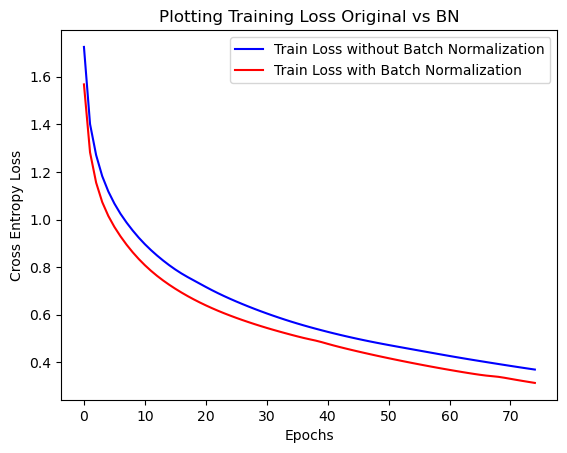

In [13]:
plt.title('Plotting Training Loss Original vs BN')
plt.plot(epochs_list, train_loss_hist, 'b', label='Train Loss without Batch Normalization')
plt.plot(epochs_list, train_loss_hist_bn, 'r', label='Train Loss with Batch Normalization')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

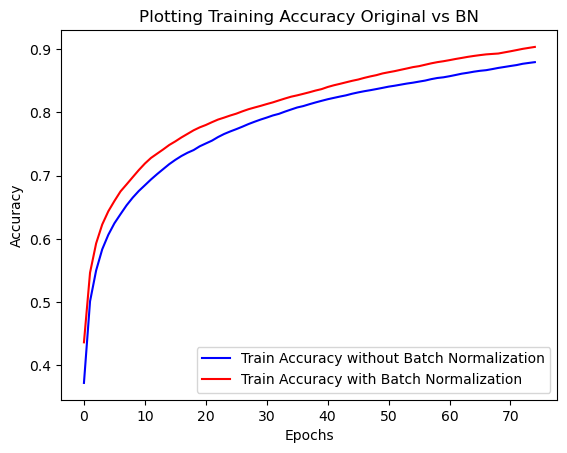

In [14]:
plt.title('Plotting Training Accuracy Original vs BN')
plt.plot(epochs_list, train_acc_hist, 'b', label='Train Accuracy without Batch Normalization')
plt.plot(epochs_list, train_acc_hist_bn, 'r', label="Train Accuracy with Batch Normalization")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

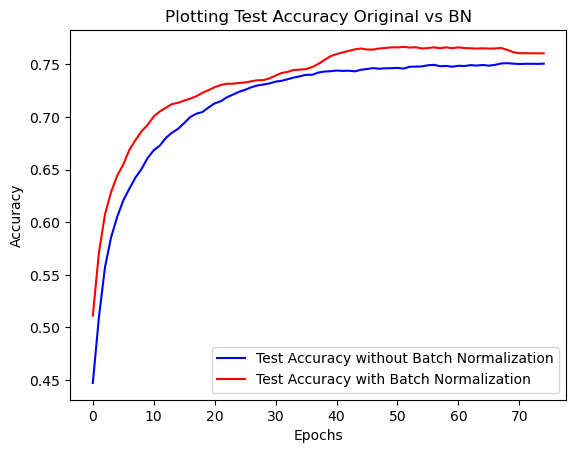

In [15]:
plt.title('Plotting Test Accuracy Original vs BN')
plt.plot(epochs_list, test_accs, 'b', label='Test Accuracy without Batch Normalization')
plt.plot(epochs_list, test_accs_bn, 'r', label="Test Accuracy with Batch Normalization")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

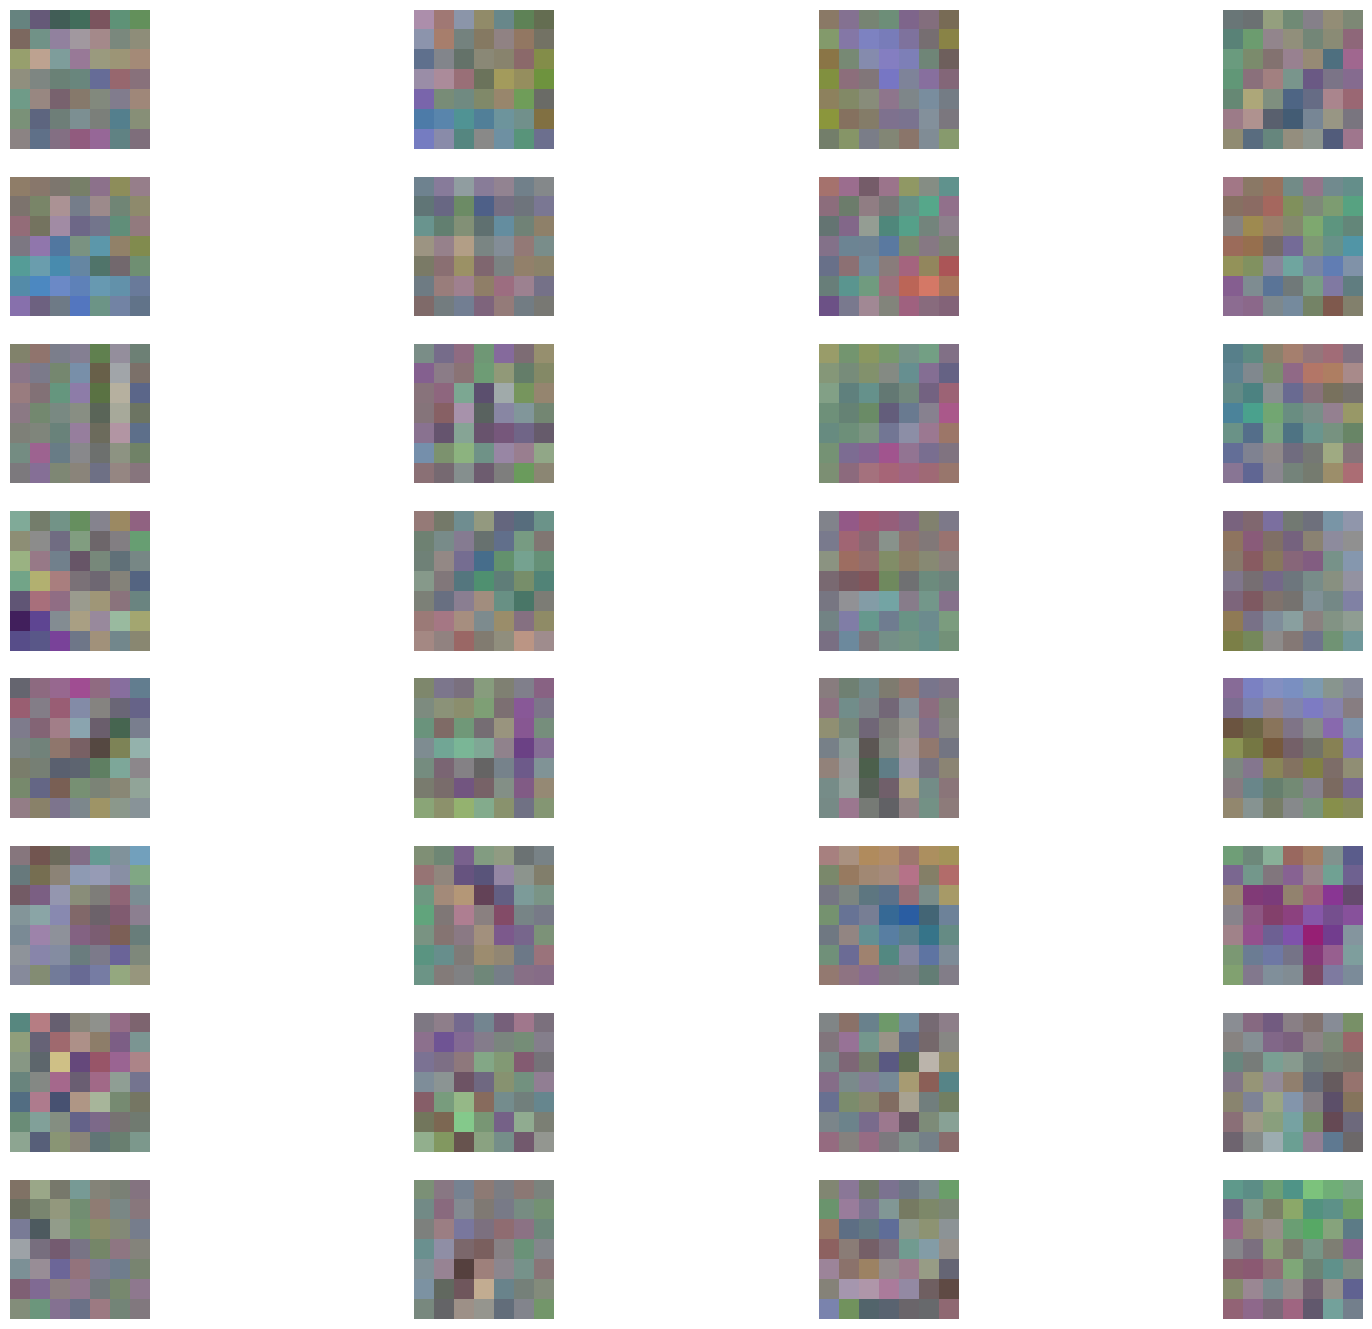

In [16]:
conv1_bn_weights = model_bn.conv1.weight.data.cpu().numpy()
plt.figure(figsize=(20, 17))
for i, filter in enumerate(conv1_bn_weights):
    f = conv1_bn_weights[i].transpose(1, 2, 0)
    norm = np.linalg.norm(f, ord=np.inf, axis=(0,1))
    eps = 1e-4
    normalized_filter = f/2*(norm + eps) + 0.5
    plt.subplot(8, 4, i+1)
    plt.imshow(normalized_filter)
    plt.axis('off')
    plt.savefig('filter_bn.png')
plt.show()

# **Normalizing Filters of Model with Batch Normalization with min max scaling**

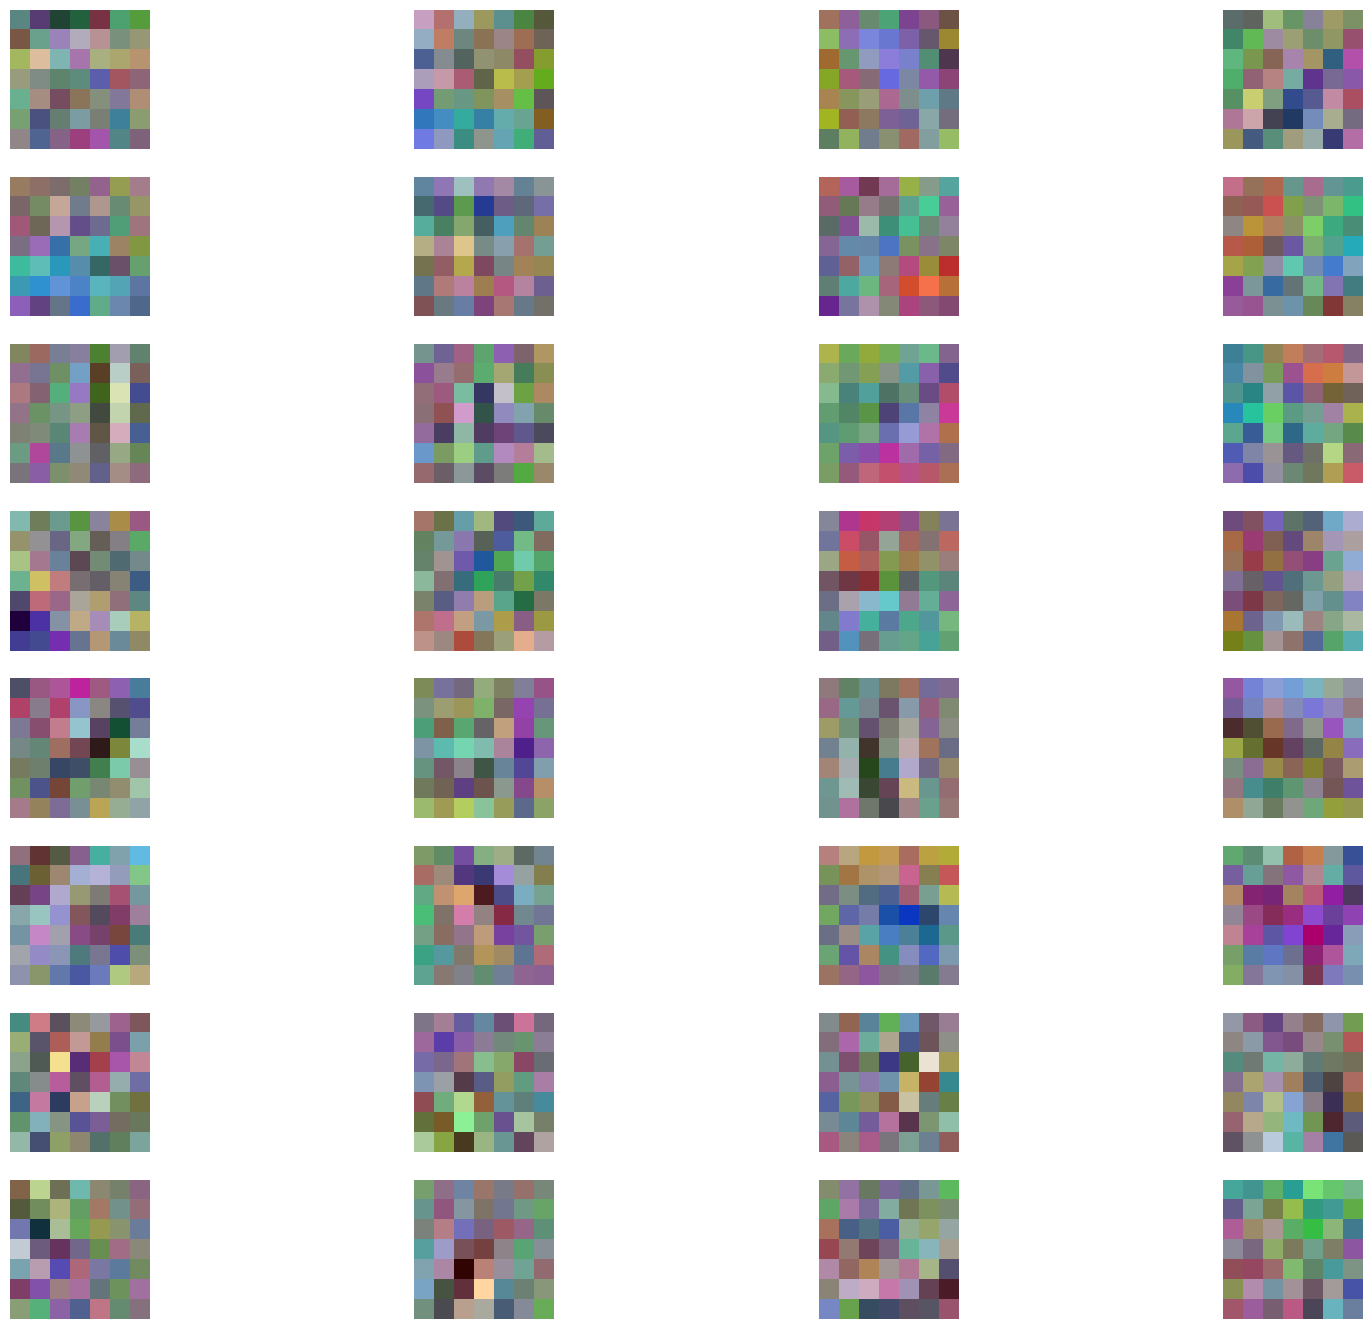

In [17]:
conv1_bn_weights = model_bn.conv1.weight.data.cpu().numpy()
conv1_bn_weights = (conv1_bn_weights - np.min(conv1_bn_weights))/(np.max(conv1_bn_weights) - np.min(conv1_bn_weights))
plt.figure(figsize=(20, 17))
for i, filter in enumerate(conv1_bn_weights):
    plt.subplot(8, 4, i+1)
    plt.imshow(conv1_bn_weights[i].transpose(1,2,0))
    plt.axis('off')
    plt.savefig('filter_bn_min_max_scaling.png')
plt.show()

In [18]:
class CustomDeepCNNBN(nn.Module):
    def __init__(self):
        super(CustomDeepCNNBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.act = nn.Mish()
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,128, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(128)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128,10)
        self.apply(self._init_weights)
        
    def _init_weights(self,m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight,1)
            torch.nn.init.constant_(m.bias,0)
            
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.act(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [19]:
model_deep = CustomDeepCNNBN()
model_deep = model_deep.cuda()
optimizer_deep = torch.optim.AdamW(model_deep.parameters(), lr=1e-3)
train_acc_hist_deep_bn, train_loss_hist_deep_bn, test_accs_deep = training(model_deep, train_loader, test_loader, 11, optimizer_deep)

Train: Epoch 1: 100%|██████████| 196/196 [00:14<00:00, 13.22it/s, loss=1.15]


Epoch 1 - Loss: 1.2933356746727107
Epoch 1 - Acc: 0.5358538031578064


Test: Epoch 1: 100%|██████████| 157/157 [00:02<00:00, 63.74it/s]


Test Accuracy: 0.5956408977508545


Train: Epoch 2: 100%|██████████| 196/196 [00:15<00:00, 12.57it/s, loss=0.859]


Epoch 2 - Loss: 0.9658974786194003
Epoch 2 - Acc: 0.6597974896430969


Test: Epoch 2: 100%|██████████| 157/157 [00:02<00:00, 53.79it/s]


Test Accuracy: 0.6589370965957642


Train: Epoch 3: 100%|██████████| 196/196 [00:14<00:00, 13.22it/s, loss=0.64]


Epoch 3 - Loss: 0.8273643632324374
Epoch 3 - Acc: 0.7116628885269165


Test: Epoch 3: 100%|██████████| 157/157 [00:02<00:00, 58.71it/s]


Test Accuracy: 0.7128781676292419


Train: Epoch 4: 100%|██████████| 196/196 [00:16<00:00, 11.85it/s, loss=0.514]


Epoch 4 - Loss: 0.7340664167185219
Epoch 4 - Acc: 0.7450693845748901


Test: Epoch 4: 100%|██████████| 157/157 [00:02<00:00, 64.42it/s]


Test Accuracy: 0.741042971611023


Train: Epoch 5: 100%|██████████| 196/196 [00:15<00:00, 12.69it/s, loss=0.439]


Epoch 5 - Loss: 0.6638917369501931
Epoch 5 - Acc: 0.7702168226242065


Test: Epoch 5: 100%|██████████| 157/157 [00:02<00:00, 61.71it/s]


Test Accuracy: 0.7541799545288086


Train: Epoch 6: 100%|██████████| 196/196 [00:16<00:00, 11.69it/s, loss=0.378]


Epoch 6 - Loss: 0.6065214930140242
Epoch 6 - Acc: 0.791569709777832


Test: Epoch 6: 100%|██████████| 157/157 [00:02<00:00, 60.11it/s]


Test Accuracy: 0.7647293210029602


Train: Epoch 7: 100%|██████████| 196/196 [00:14<00:00, 13.30it/s, loss=0.321]


Epoch 7 - Loss: 0.5578175308753033
Epoch 7 - Acc: 0.8086695075035095


Test: Epoch 7: 100%|██████████| 157/157 [00:02<00:00, 62.96it/s]


Test Accuracy: 0.7713972926139832


Train: Epoch 8: 100%|██████████| 196/196 [00:16<00:00, 11.87it/s, loss=0.273]


Epoch 8 - Loss: 0.5151642678039414
Epoch 8 - Acc: 0.8227638602256775


Test: Epoch 8: 100%|██████████| 157/157 [00:02<00:00, 63.01it/s]


Test Accuracy: 0.7740843892097473


Train: Epoch 9: 100%|██████████| 196/196 [00:14<00:00, 13.25it/s, loss=0.236]


Epoch 9 - Loss: 0.47652867907772256
Epoch 9 - Acc: 0.8364596366882324


Test: Epoch 9: 100%|██████████| 157/157 [00:03<00:00, 51.54it/s]


Test Accuracy: 0.7756767272949219


Train: Epoch 10: 100%|██████████| 196/196 [00:15<00:00, 12.69it/s, loss=0.205]


Epoch 10 - Loss: 0.4405534709898793
Epoch 10 - Acc: 0.8508091568946838


Test: Epoch 10: 100%|██████████| 157/157 [00:02<00:00, 61.90it/s]


Test Accuracy: 0.7820461988449097


Train: Epoch 11: 100%|██████████| 196/196 [00:14<00:00, 13.18it/s, loss=0.177]


Epoch 11 - Loss: 0.4064248160135989
Epoch 11 - Acc: 0.8629544377326965


Test: Epoch 11: 100%|██████████| 157/157 [00:03<00:00, 44.53it/s]

Test Accuracy: 0.7857285141944885


In [20]:
#test_acc_deep = predict(model_deep, test_loader)
print(f'Test Accuracy of the deeper model on the CIFAR-10 Test set: {max(test_accs_deep)*100}%')

Test Accuracy of the deeper model on the CIFAR-10 Test set: 78.5728530883789%


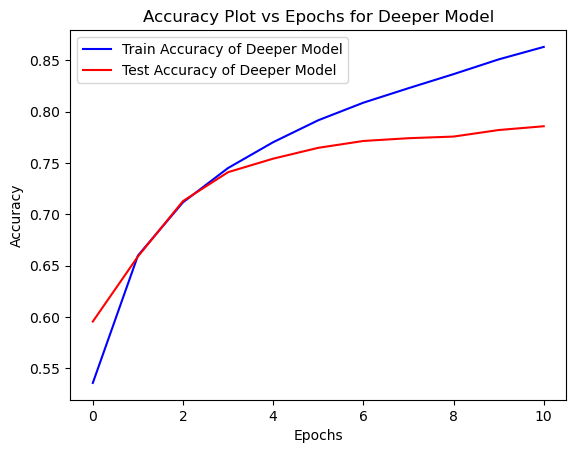

In [21]:
epochs_small_list = [i for i in range(11)]
plt.title('Accuracy Plot vs Epochs for Deeper Model')
plt.plot(epochs_small_list, train_acc_hist_deep_bn, 'b', label='Train Accuracy of Deeper Model')
plt.plot(epochs_small_list, test_accs_deep, 'r', label='Test Accuracy of Deeper Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

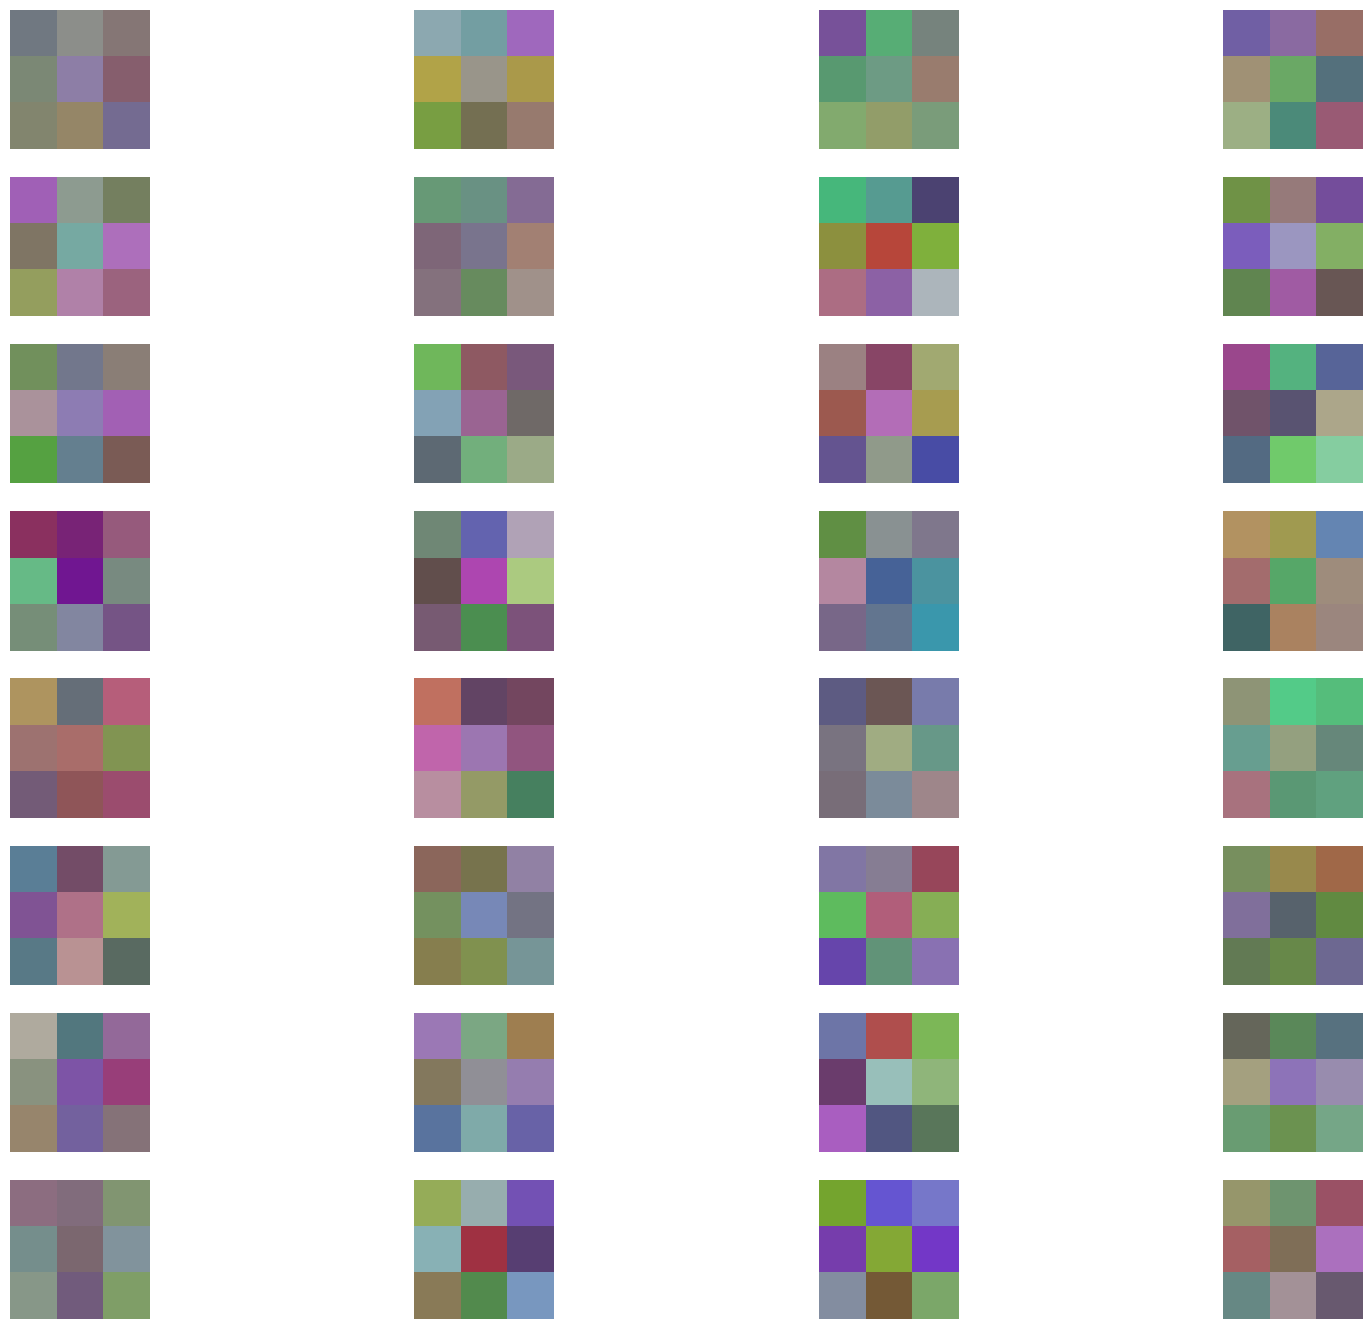

In [22]:
conv1_deep_weights = model_deep.conv1.weight.data.cpu().numpy()
plt.figure(figsize=(20, 17))
for i, filter in enumerate(conv1_deep_weights):
    f = conv1_deep_weights[i].transpose(1, 2, 0)
    norm = np.linalg.norm(f, ord=np.inf, axis=(0,1))
    eps = 1e-4
    normalized_filter = f/2*(norm + eps) + 0.5
    plt.subplot(8, 4, i+1)
    plt.imshow(normalized_filter)
    plt.axis('off')
    plt.savefig('filters_deep_model.png')
plt.show()